<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs_TF2.x/blob/main/EBGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EBGAN**

## **Imports**

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

## **Hyperparameters**

In [2]:
lr = 0.0002
epochs = 20
batch_size = 128

z_dim = 100 
nf =64
lambda_pt = 0.1

## **Data Preprocessing**

In [3]:
(x_train, _), _ = mnist.load_data()
x_train = (x_train.astype(np.float32)-127.5) / 127.5
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size).prefetch(1)

11493376/11490434 [==============================] - 0s 0us/step


## **Model**

In [4]:
class Generator(Model):
    def __init__(self, nf):
        super(Generator, self).__init__()
        self.fc = tf.keras.Sequential([layers.Dense(7 * 7 * nf * 4),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Reshape((7, 7, nf * 4))
                                       ])
        self.conv1 = tf.keras.Sequential([layers.Conv2DTranspose(nf * 2, 3, strides=1, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv2 = tf.keras.Sequential([layers.Conv2DTranspose(nf, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv3 = layers.Conv2DTranspose(1, 3, strides=2, padding='SAME')


    def call(self, x):
        x = self.fc(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = tf.nn.tanh(x)
        return x

In [5]:
class Discriminator(Model):
    def __init__(self, nf):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.Sequential([layers.Conv2D(nf * 2, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv2 = tf.keras.Sequential([layers.Conv2D(nf * 4, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv3 = tf.keras.Sequential([layers.Conv2D(nf * 4, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Flatten()
                                       ])
        self.embedding = layers.Dense(128)
        self.fc = tf.keras.Sequential([layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Dense(7 * 7 * nf * 2),
                                       layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Reshape((7, 7, nf * 2))
                                       ])
        self.deconv1 = tf.keras.Sequential([layers.Conv2DTranspose(64, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.deconv2 = layers.Conv2DTranspose(1, 3, strides=2, padding='SAME')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        embedding = self.embedding(x)
        x = self.fc(embedding)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x= tf.squeeze(x)
        return x, embedding


In [6]:
G = Generator(nf)
D = Discriminator(nf)

## **Loss Function**

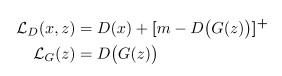

In [7]:
def MSE_loss(reconstructed, original):
    gen_loss = tf.reduce_mean(tf.pow(original - reconstructed, 2))
    return gen_loss

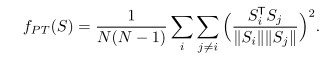

In [8]:
def PT_loss(embeddings):
    norm = tf.sqrt(tf.reduce_sum(embeddings ** 2, -1, keepdims=True))
    normalized_emb = embeddings / norm
    similarity = tf.matmul(normalized_emb, tf.transpose(normalized_emb,perm=[1, 0]))
    batch_size = embeddings.shape[0]
    loss_pt = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return loss_pt

## **Train**

In [9]:
optimizer_G = tf.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)
optimizer_D = tf.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)

In [10]:
for epoch in range(epochs):
    for imgs in train_data:
        noise = tf.random.normal(shape=[batch_size, z_dim])
        margin =  max(1, batch_size / 64.0)

        with tf.GradientTape() as g:
                
            fake_images = G(noise)
            recon_fake,_ = D(fake_images)
            recon_real,_ = D(imgs)


            D_loss = MSE_loss(recon_real, imgs) + tf.maximum(0, margin - MSE_loss(recon_fake, tf.squeeze(fake_images)))

        gradients_D = g.gradient(D_loss,  D.trainable_variables)
        optimizer_D.apply_gradients(zip(gradients_D,  D.trainable_variables))

        noise = tf.random.normal(shape=[batch_size, z_dim])

        with tf.GradientTape() as g:
                
            fake_images = G(noise)
            recon_fake,embeddings = D(fake_images)
          
            G_loss = MSE_loss(recon_fake, tf.squeeze(fake_images)) + lambda_pt*PT_loss(embeddings)

        gradients_G = g.gradient(G_loss,  G.trainable_variables)
        optimizer_G.apply_gradients(zip(gradients_G,  G.trainable_variables))
    
        
    print(f"epoch: {epoch+1}/{epochs}, G_loss: {G_loss}, D_loss: {D_loss}")

epoch: 1/20, G_loss: 2.141690254211426, D_loss: 0.661440372467041
epoch: 2/20, G_loss: 2.0739386081695557, D_loss: 1.9765585660934448
epoch: 3/20, G_loss: 1.526235818862915, D_loss: 1.7063417434692383
epoch: 4/20, G_loss: 2.172741651535034, D_loss: 1.2949352264404297
epoch: 5/20, G_loss: 2.125450849533081, D_loss: 0.4808059632778168
epoch: 6/20, G_loss: 2.479526996612549, D_loss: 0.5639049410820007
epoch: 7/20, G_loss: 3.753418207168579, D_loss: 0.7297188639640808
epoch: 8/20, G_loss: 1.7595998048782349, D_loss: 0.31107184290885925
epoch: 9/20, G_loss: 4.327711582183838, D_loss: 0.7461058497428894
epoch: 10/20, G_loss: 4.697973251342773, D_loss: 0.6647725105285645
epoch: 11/20, G_loss: 2.1197943687438965, D_loss: 0.2982529103755951
epoch: 12/20, G_loss: 4.475893974304199, D_loss: 1.2543387413024902
epoch: 13/20, G_loss: 1.586119294166565, D_loss: 0.3127325773239136
epoch: 14/20, G_loss: 2.7441372871398926, D_loss: 0.34865283966064453
epoch: 15/20, G_loss: 1.6654722690582275, D_loss: 0.

## **Visualization**

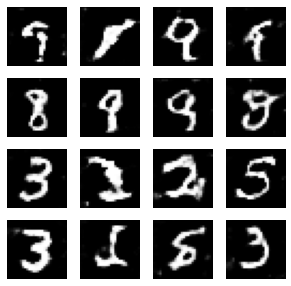

In [11]:
n = 4
z = tf.random.normal(shape=[n**2, z_dim])
gen_imgs = G(z, training=False)

fig = plt.figure(figsize=(5,5))

for i in range(gen_imgs.shape[0]):
    plt.subplot(n, n, i+1)
    plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()